In [5]:
import os

import kagglehub
import numpy as np
import pandas as pd
from dataclasses import dataclass
from torch import tensor, nn, no_grad, float32
from torch.utils.data import TensorDataset, DataLoader
import torch
import copy
from torch.utils.data import random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.base import clone
from scipy.stats import loguniform
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, \
    StackingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, KFold, StratifiedShuffleSplit, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from typing_extensions import override
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline

PATH_TO_DATASET = os.path.join(kagglehub.dataset_download("salvatorerastelli/spotify-and-youtube"),
                               "Spotify_Youtube.csv")

# Reading the dataset
While dropping unneeded columns, similarly to the first part. Additional columns that are dropped: 'Artist'

In [6]:
df = pd.read_csv(PATH_TO_DATASET)
NUMERIC_COLUMNS = ['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness',
                   'Liveness', 'Valence', 'Tempo', 'Duration_ms', 'Views', 'Likes', 'Comments', 'Stream']
CATEGORICAL_COLUMNS = ['Album_type', 'Licensed', 'official_video']
df.drop(
    columns=['Description', 'Url_youtube', 'Url_spotify', 'Uri', 'Title', 'Channel', 'Album', 'Track', 'Unnamed: 0', 'Artist'],
    axis=1, inplace=True)
df.describe()

,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,Likes,Comments,Stream
count,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,2.071600e+04,2.024800e+04,2.017700e+04,2.014900e+04,2.014200e+04
mean,0.619777,0.635250,5.300348,-7.671680,0.096456,0.291535,0.055962,0.193521,0.529853,120.638340,2.247176e+05,9.393782e+07,6.633411e+05,2.751899e+04,1.359422e+08
std,0.165272,0.214147,3.576449,4.632749,0.111960,0.286299,0.193262,0.168531,0.245441,29.579018,1.247905e+05,2.746443e+08,1.789324e+06,1.932347e+05,2.441321e+08
min,0.000000,0.000020,0.000000,-46.251000,0.000000,0.000001,0.000000,0.014500,0.000000,0.000000,3.098500e+04,0.000000e+00,0.000000e+00,0.000000e+00,6.574000e+03
25%,0.518000,0.507000,2.000000,-8.858000,0.035700,0.045200,0.000000,0.094100,0.339000,97.002000,1.800095e+05,1.826002e+06,2.158100e+04,5.090000e+02,1.767486e+07
50%,0.637000,0.666000,5.000000,-6.536000,0.050500,0.193000,0.000002,0.125000,0.537000,119.965000,2.132845e+05,1.450110e+07,1.244810e+05,3.277000e+03,4.968298e+07
75%,0.740250,0.798000,8.000000,-4.931000,0.103000,0.477250,0.000463,0.237000,0.726250,139.935000,2.524430e+05,7.039975e+07,5.221480e+05,1.436000e+04,1.383581e+08
max,0.975000,1.000000,11.000000,0.920000,0.964000,0.996000,1.000000,1.000000,0.993000,243.372000,4.676058e+06,8.079649e+09,5.078865e+07,1.608314e+07,3.386520e+09


### Normalizing Loudness metric


In [7]:
df['Loudness']= MinMaxScaler(feature_range=(0, 1)).fit_transform(df[['Loudness']])
df.describe()

,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,Likes,Comments,Stream
count,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,20716.000000,2.071600e+04,2.024800e+04,2.017700e+04,2.014900e+04,2.014200e+04
mean,0.619777,0.635250,5.300348,0.817861,0.096456,0.291535,0.055962,0.193521,0.529853,120.638340,2.247176e+05,9.393782e+07,6.633411e+05,2.751899e+04,1.359422e+08
std,0.165272,0.214147,3.576449,0.098212,0.111960,0.286299,0.193262,0.168531,0.245441,29.579018,1.247905e+05,2.746443e+08,1.789324e+06,1.932347e+05,2.441321e+08
min,0.000000,0.000020,0.000000,0.000000,0.000000,0.000001,0.000000,0.014500,0.000000,0.000000,3.098500e+04,0.000000e+00,0.000000e+00,0.000000e+00,6.574000e+03
25%,0.518000,0.507000,2.000000,0.792712,0.035700,0.045200,0.000000,0.094100,0.339000,97.002000,1.800095e+05,1.826002e+06,2.158100e+04,5.090000e+02,1.767486e+07
50%,0.637000,0.666000,5.000000,0.841937,0.050500,0.193000,0.000002,0.125000,0.537000,119.965000,2.132845e+05,1.450110e+07,1.244810e+05,3.277000e+03,4.968298e+07
75%,0.740250,0.798000,8.000000,0.875962,0.103000,0.477250,0.000463,0.237000,0.726250,139.935000,2.524430e+05,7.039975e+07,5.221480e+05,1.436000e+04,1.383581e+08
max,0.975000,1.000000,11.000000,1.000000,0.964000,0.996000,1.000000,1.000000,0.993000,243.372000,4.676058e+06,8.079649e+09,5.078865e+07,1.608314e+07,3.386520e+09


### Scaling the overly spread metrics: Likes, Views, Comments and Streams
In contrast to the first part, the values will be scaled using a logarithmic scale instead of the outliers being capped, with the bottom 3% being dropped completely (songs with a dismal amount of attention).

In [8]:
display("Size before dropping outliers: ", df.shape)
thresholds = {column_name: df[column_name].quantile(0.03) for column_name in ['Views', 'Likes', 'Comments', 'Stream']}
mask = df[list(thresholds.keys())].gt(pd.Series(thresholds)).all(axis=1)
df = df[mask]
display("Size after dropping outliers: ", df.shape)

'Size before dropping outliers: '

(20718, 18)

'Size after dropping outliers: '

(18187, 18)

In [9]:
df.loc[:, 'Views'] = np.log10(df['Views'])
df.loc[:, 'Likes'] = np.log10(df['Likes'])
df.loc[:, 'Comments'] = np.log10(df['Comments'])
df.loc[:, 'Stream'] = np.log10(df['Stream'])
df.describe()

,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Views,Likes,Comments,Stream
count,18186.000000,18186.000000,18186.000000,18186.000000,18186.000000,18186.000000,18186.000000,18186.000000,18186.000000,18186.000000,1.818600e+04,18187.000000,18187.000000,18187.000000,18187.000000
mean,0.624021,0.640492,5.308644,0.823122,0.092491,0.282504,0.049100,0.190521,0.532134,120.834939,2.260323e+05,7.139007,5.100764,3.531662,7.743577
std,0.162479,0.207076,3.575914,0.089913,0.094687,0.279682,0.180283,0.164621,0.242895,29.389313,1.240275e+05,1.030558,0.931282,0.984654,0.623354
min,0.000000,0.001250,0.000000,0.091560,0.000000,0.000002,0.000000,0.014500,0.000000,0.000000,3.500000e+04,4.260167,2.413300,0.477121,6.189394
25%,0.522000,0.517000,2.000000,0.798075,0.035500,0.043700,0.000000,0.094000,0.343000,97.028000,1.819910e+05,6.465060,4.519001,2.924796,7.319701
50%,0.640000,0.668000,5.000000,0.843665,0.050600,0.186000,0.000002,0.125000,0.538000,119.973000,2.144520e+05,7.255736,5.183307,3.609594,7.743738
75%,0.743000,0.797000,8.000000,0.876768,0.103000,0.458000,0.000342,0.232000,0.728000,139.969000,2.527330e+05,7.893353,5.760114,4.209917,8.172799
max,0.975000,1.000000,11.000000,1.000000,0.944000,0.996000,1.000000,1.000000,0.993000,243.372000,4.581483e+06,9.907393,7.705767,7.206371,9.529754


### Reducing the skew of the data

#### Goal: |Skewness| < 2.0
Columns 'Intrumentalness', 'Loudness', 'Liveness' and 'Speechiness' have a highly skewed distribution that will affect the machine learning models.
Column describing the duration of the song has a skewness of over 24 – with approximately the top 1% amounting to all the skew.
Histograms displaying the skew below.

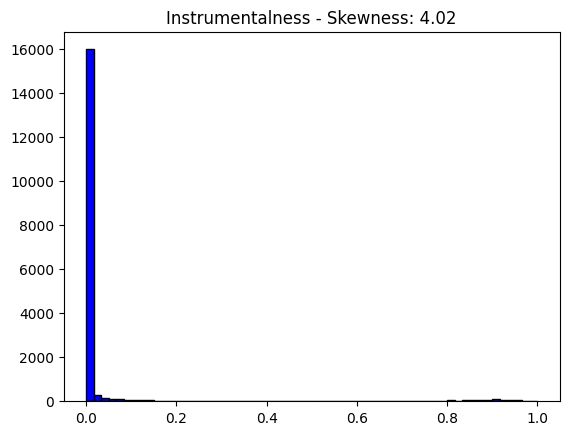

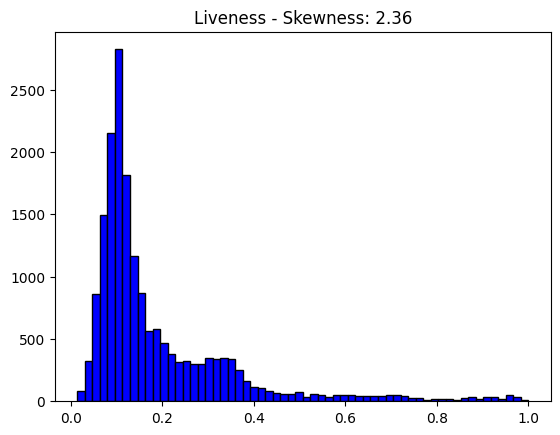

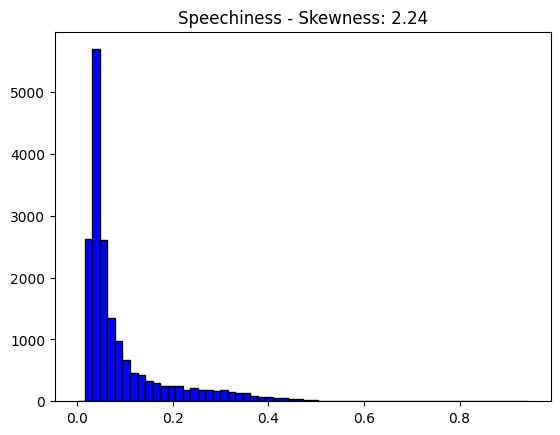

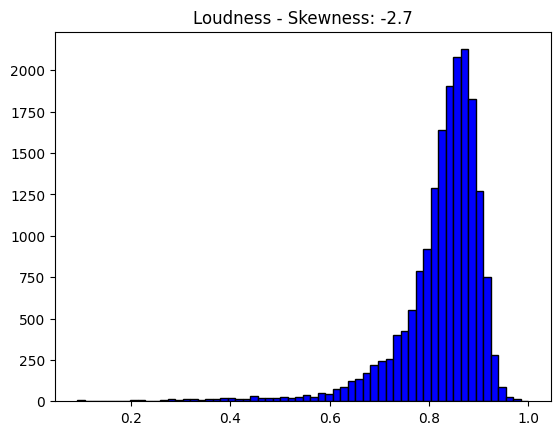

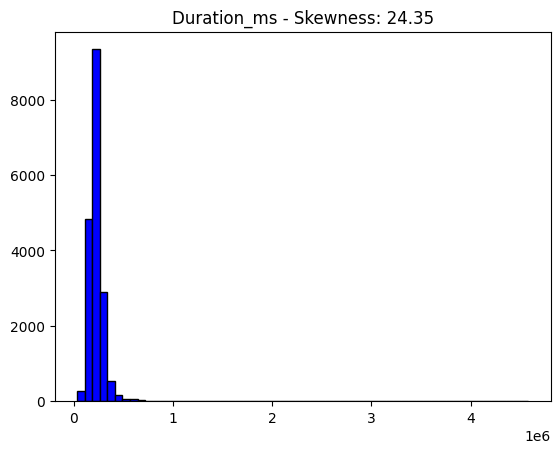

In [10]:
for column in ['Instrumentalness', 'Liveness', 'Speechiness', 'Loudness', 'Duration_ms']:
    plt.hist(df[column], bins=60, color='blue', edgecolor='black')
    plt.title(f'{column} - Skewness: {str(round(df[column].skew(), 2))}')
    plt.plot()
    plt.show()
    plt.close()

### Redefining the 'Instrumentalness' metric
The value of the metric is either extremely close to zero or, with a tiny number of songs, close to one. As such, it will be replaced with a binary variable.
- Value < 0.1 → False
- Value >= 0.1 → True


New metric name: `IsInstrumental`

In [11]:
df['Instrumentalness']=  df['Instrumentalness'].apply(lambda x: True if x is not None and x >= 0.1 else False)
display(df['Instrumentalness'].isnull().sum())
print(df['Instrumentalness'].value_counts())
print(df['Instrumentalness'])
NUMERIC_COLUMNS.remove('Instrumentalness')
CATEGORICAL_COLUMNS.append('Instrumentalness')

np.int64(0)

Instrumentalness
False    16726
True      1461
Name: count, dtype: int64
0        False
1        False
2        False
3         True
4        False
         ...  
20694    False
20695    False
20696    False
20697    False
20698    False
Name: Instrumentalness, Length: 18187, dtype: bool


### Reducing the right (positive) skews for 'Liveness', 'Speechiness'
Using Square Root Transformation since the data is not extremely skewed.

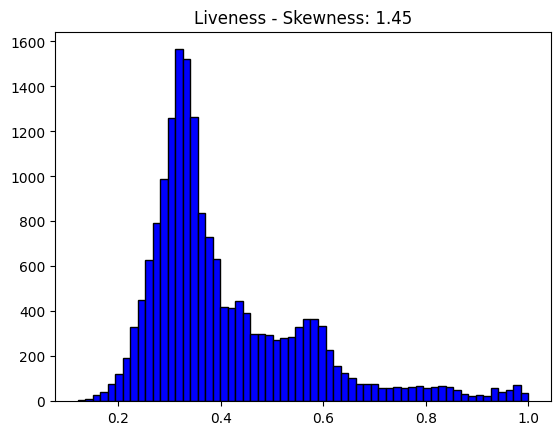

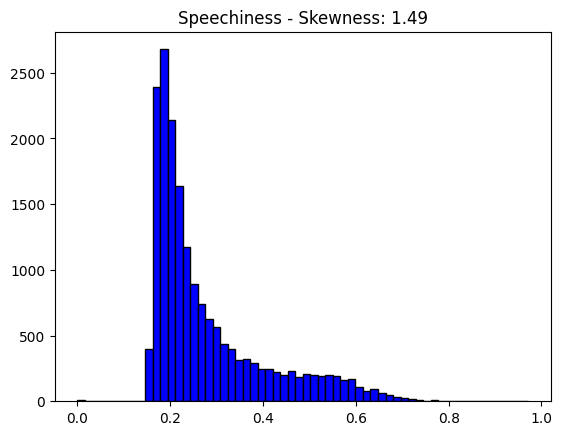

In [12]:
for column in ['Liveness', 'Speechiness']:
    df[column] = np.sqrt(df[column])
    plt.hist(df[column], bins=60, color='blue', edgecolor='black')
    plt.title(f'{column} - Skewness: {str(round(df[column].skew(), 2))}')
    plt.plot()
    plt.show()
    plt.close()

##### Capping the top outliers for duration
Value `0.987` was chosen to provide the best compromise between reducing the skew and retaining the data distribution.

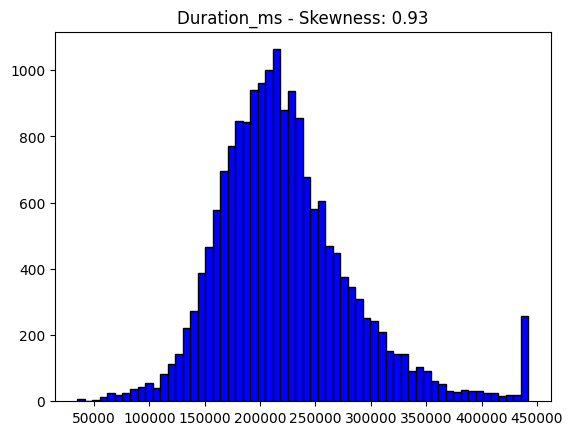

In [13]:
threshold = df['Duration_ms'].quantile(0.987)
df['Duration_ms'] = df['Duration_ms'].clip(upper=threshold)
plt.hist(df['Duration_ms'], bins=60, color='blue', edgecolor='black')
plt.title(f'Duration_ms - Skewness: {str(round(df['Duration_ms'].skew(), 2))}')
plt.plot()
plt.show()
plt.close()

### Reducing the left (negative) skews for 'Loudness'
Using lower Winsorization to limit the close to zero values. `0.013` chosen to reduce the skew under 2.0 without capping too many values.

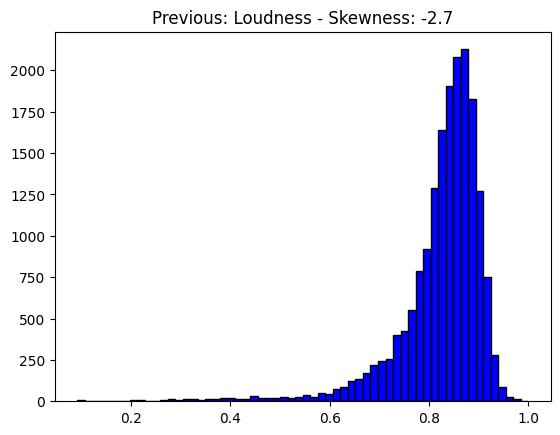

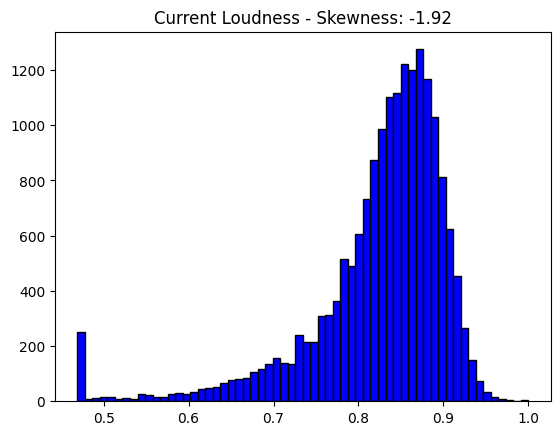

In [14]:
plt.hist(df['Loudness'], bins=60, color='blue', edgecolor='black')
plt.title(f'Previous: Loudness - Skewness: {str(round(df['Loudness'].skew(), 2))}')
plt.plot()
plt.show()
plt.close()
df['Loudness'] = df['Loudness'].clip(lower=df['Loudness'].quantile(0.013))
plt.hist(df['Loudness'], bins=60, color='blue', edgecolor='black')
plt.title(f'Current Loudness - Skewness: {str(round(df['Loudness'].skew(), 2))}')
plt.plot()
plt.show()
plt.close()

# Creating the pipelines

### Predicting the song's instrumentallness

In [15]:
target = 'Instrumentalness'
X = df.drop(columns=[target], axis=1)
y = df[target]
NEW_CATEGORICAL_COLUMNS = CATEGORICAL_COLUMNS.copy()
NEW_CATEGORICAL_COLUMNS.remove(target)

#### Create preprocessing pipelines


In [16]:
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_pipeline, NUMERIC_COLUMNS),
        ('categorical', categorical_pipeline, NEW_CATEGORICAL_COLUMNS),
    ]
)

#### Define the model pipeline

In [18]:
model_pipelines: dict[str, Pipeline] = {}

def add_model_pipeline(classifier, name: str):
    model_pipelines[name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

In [19]:
add_model_pipeline(LogisticRegression(max_iter=1000), 'logReg')
add_model_pipeline(RandomForestClassifier(random_state=42), 'rfc')
add_model_pipeline(SVC(), 'svc')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Train the model

In [21]:
for pipeline in model_pipelines.values():
    pipeline.fit(X_train, y_train)

#### Training set results


In [22]:
for pipeline_name, pipeline in model_pipelines.items():
    print(f"Model: {pipeline_name}")
    y_pred = pipeline.predict(X_train)
    print("Accuracy:", accuracy_score(y_train, y_pred))
    print("Classification Report:\n", classification_report(y_train, y_pred))

Model: logReg
Accuracy: 0.9402020757440374
Classification Report:
               precision    recall  f1-score   support

       False       0.94      0.99      0.97     13393
        True       0.81      0.32      0.46      1156

    accuracy                           0.94     14549
   macro avg       0.88      0.66      0.71     14549
weighted avg       0.93      0.94      0.93     14549

Model: rfc
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     13393
        True       1.00      1.00      1.00      1156

    accuracy                           1.00     14549
   macro avg       1.00      1.00      1.00     14549
weighted avg       1.00      1.00      1.00     14549

Model: svc
Accuracy: 0.9430201388411574
Classification Report:
               precision    recall  f1-score   support

       False       0.94      1.00      0.97     13393
        True       0.93      0.31      0.46      1156

  

#### Test set results

In [23]:
for pipeline_name, pipeline in model_pipelines.items():
    print(f"Model: {pipeline_name}")
    y_pred = pipeline.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))

Model: logReg
Accuracy: 0.936778449697636
Classification Report:
               precision    recall  f1-score   support

       False     0.9411    0.9931    0.9664      3333
        True     0.8099    0.3213    0.4601       305

    accuracy                         0.9368      3638
   macro avg     0.8755    0.6572    0.7133      3638
weighted avg     0.9301    0.9368    0.9240      3638

Model: rfc
Accuracy: 0.94282572842221
Classification Report:
               precision    recall  f1-score   support

       False     0.9450    0.9955    0.9696      3333
        True     0.8819    0.3672    0.5185       305

    accuracy                         0.9428      3638
   macro avg     0.9135    0.6814    0.7441      3638
weighted avg     0.9397    0.9428    0.9318      3638

Model: svc
Accuracy: 0.9392523364485982
Classification Report:
               precision    recall  f1-score   support

       False     0.9395    0.9979    0.9678      3333
        True     0.9286    0.2984    0.4516  

#### Balancing the dataset
Since vast majority (over 90%) of the songs are deemed as not instrumentall, we will oversample the instrumentall ones

In [24]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(split.split(X, y))
X_res_train, X_res_test = X.iloc[train_index], X.iloc[test_index]
y_res_train, y_res_test = y.iloc[train_index], y.iloc[test_index]

res_model_pipelines: dict[str, Pipeline] = {}

tomek = TomekLinks(sampling_strategy='majority')
smote = SMOTE(random_state=42)
resampler = SMOTETomek(random_state=42, tomek=tomek, smote=smote)


def add_res_model_pipeline(classifier, name: str):
    res_model_pipelines[name] = ImblearnPipeline(steps=[
        ('preprocessor', preprocessor),
        ('resampler', resampler),
        ('classifier', classifier)
    ])

add_res_model_pipeline(LogisticRegression(max_iter=1000), 'logReg')
add_res_model_pipeline(RandomForestClassifier(random_state=42), 'rfc')
add_res_model_pipeline(SVC(), 'svc')

#### Train the models again

In [25]:
for pipeline in res_model_pipelines.values():
    pipeline.fit(X_res_train, y_res_train)

#### Training data metrics

In [26]:
for pipeline_name, pipeline in res_model_pipelines.items():
    print(f"Model: {pipeline_name}")
    y_pred = pipeline.predict(X_res_train)
    print("Classification Report:\n", classification_report(y_res_train, y_pred))

Model: logReg
Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.81      0.88     13380
        True       0.26      0.76      0.39      1169

    accuracy                           0.81     14549
   macro avg       0.62      0.78      0.63     14549
weighted avg       0.92      0.81      0.84     14549

Model: rfc
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00     13380
        True       1.00      1.00      1.00      1169

    accuracy                           1.00     14549
   macro avg       1.00      1.00      1.00     14549
weighted avg       1.00      1.00      1.00     14549

Model: svc
Classification Report:
               precision    recall  f1-score   support

       False       0.99      0.88      0.93     13380
        True       0.38      0.86      0.52      1169

    accuracy                           0.87     14549
   macro avg       0

#### Test data metrics

In [27]:
for pipeline_name, pipeline in res_model_pipelines.items():
    print(f"Model: {pipeline_name}")
    y_pred = pipeline.predict(X_res_test)
    print("Classification Report:\n", classification_report(y_res_test, y_pred, digits=4))

Model: logReg
Classification Report:
               precision    recall  f1-score   support

       False     0.9739    0.8019    0.8795      3346
        True     0.2492    0.7534    0.3745       292

    accuracy                         0.7980      3638
   macro avg     0.6115    0.7776    0.6270      3638
weighted avg     0.9157    0.7980    0.8390      3638

Model: rfc
Classification Report:
               precision    recall  f1-score   support

       False     0.9563    0.9603    0.9582      3346
        True     0.5216    0.4966    0.5088       292

    accuracy                         0.9230      3638
   macro avg     0.7389    0.7284    0.7335      3638
weighted avg     0.9214    0.9230    0.9222      3638

Model: svc
Classification Report:
               precision    recall  f1-score   support

       False     0.9704    0.8539    0.9084      3346
        True     0.2954    0.7021    0.4158       292

    accuracy                         0.8417      3638
   macro avg     0.6

##  Regression implementation

Goal: try to predict the number of song's streams on Spotify based on YouTube metrics and song licensing

#### Defining the custom models

In [28]:
from abc import ABC

class CustomModel(ABC):
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None

    def fit(self, X, y):
       pass

    def predict(self, X):
        if self.coef_ is None:
            raise ValueError("Model is not fitted yet.")
        if X.ndim == 1:
            X = X.reshape(1, -1)
        X = np.asarray(X).astype(np.float64)
        return X.dot(self.coef_) + self.intercept_

    def score(self, X, y):
        X = np.asarray(X).astype(np.float64)
        y = np.asarray(y).astype(np.float64)
        y_pred = self.predict(X)
        u = ((y - y_pred) ** 2).sum()
        v = ((y - y.mean()) ** 2).sum()
        return 1 - (u / v) if v != 0 else 0.0

    @staticmethod
    def prepare_data(X, y) -> tuple[np.ndarray, np.ndarray]:
        X = np.asarray(X).astype(np.float64)
        y = np.asarray(y).astype(np.float64)
        if y.ndim > 1 and y.shape[1] == 1:
            y = y.ravel()
        return X, y

class CustomLinearRegression(CustomModel):

    def fit(self, X, y):
        X, y = self.prepare_data(X, y)
        X_design = np.c_[np.ones(X.shape[0]), X]
        weights, _, _, _ = np.linalg.lstsq(X_design, y, rcond=None)
        self.intercept_ = weights[0]
        self.coef_ = weights[1:]
        return self

class CustomGradientDescentRegression(CustomModel):
    def __init__(self, learning_rate=0.15, n_iterations=1000, tol=1e-3, random_state=42):
        super().__init__()
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.tol = tol
        self.cost_history_ = []
        if random_state is not None:
            np.random.seed(random_state)

    @staticmethod
    def _get_msqe_cost(X, y, theta):
        return (1 / len(y)) * np.sum(np.square(X.dot(theta) - y))

    def fit(self, X, y):
        X, y = self.prepare_data(X, y)
        m, n = X.shape
        X_with_intercept = np.c_[np.ones(m), X]
        theta = np.random.randn(n + 1)
        prev_cost = float('inf')
        self.cost_history_ = []

        for i in range(self.n_iterations):
            theta = self._calculate_theta(X_with_intercept, y, theta, m)
            current_cost = self._update_cost(X_with_intercept, y, theta)
            if self._should_stop(prev_cost, current_cost):
                break
            prev_cost = current_cost
        self.intercept_ = theta[0]
        self.coef_ = theta[1:]
        return self

    def _calculate_theta(self, X, y, old_theta, m):
        predictions = X.dot(old_theta)
        gradient = (1 /m) * X.T.dot(predictions - y)
        return old_theta - self.learning_rate * gradient

    def _should_stop(self, prev_cost, current_cost) -> bool:
        return current_cost < self.tol or abs(prev_cost - current_cost) < self.tol

    def _update_cost(self, X, y, theta) -> np.float64:
        current_cost = self._get_msqe_cost(X, y, theta)
        self.cost_history_.append(current_cost)
        return current_cost

class CustomGradientDescentRegWithBatches(CustomGradientDescentRegression):
    def __init__(self, learning_rate=0.15, n_iterations=1000, tol=1e-3, random_state=42, batch_size=64):
        super().__init__(learning_rate, n_iterations, tol, random_state)
        self.batch_size = batch_size

    @override
    def fit(self, X, y):
        X, y = self.prepare_data(X, y)
        m, n = X.shape
        X_with_intercept = np.c_[np.ones(m), X]
        theta = np.random.randn(n + 1)
        prev_cost = float('inf')
        self.cost_history_ = []
        indices = np.arange(m)

        for i in range(self.n_iterations):
            np.random.shuffle(indices)

            for start_idx in range(0, m, self.batch_size):
                batch_indices = indices[start_idx:min(start_idx + self.batch_size, m)]
                X_batch = X_with_intercept[batch_indices]
                y_batch = y[batch_indices]
                theta = self._calculate_theta(X_batch, y_batch, theta, len(y_batch))

            current_cost = self._update_cost(X_with_intercept, y, theta)
            if self._should_stop(prev_cost, current_cost):
                break
            prev_cost = current_cost

        self.intercept_ = theta[0]
        self.coef_ = theta[1:]
        return self

#### Define the new pipeline
Target value: number of streams
Predictions based on: YouTube metrics and song licensing

In [29]:
target = 'Loudness'
BASE_CAT_COLUMNS = CATEGORICAL_COLUMNS.copy()
BASE_NUM_COLUMNS = NUMERIC_COLUMNS.copy()
BASE_NUM_COLUMNS.remove(target)
columns_preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_pipeline,  BASE_NUM_COLUMNS),
        ('categorical', categorical_pipeline, BASE_CAT_COLUMNS)]
)
spotify_preprocessor = Pipeline(
    steps=[
        ('column', columns_preprocessor)
    ]
)
X = df[BASE_NUM_COLUMNS + BASE_CAT_COLUMNS].copy()
y = df[target].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
y_train = y_train.fillna(df[target].median())
y_test = y_test.fillna(df[target].median())

#### Train the models


In [30]:
spotify_model_pipelines: dict[str, Pipeline] = {}

def add_spotify_model_pipeline(regressor, name: str, pipeline_set=None):
    if pipeline_set is None:
        pipeline_set = spotify_model_pipelines
    pipeline_set[name] = Pipeline(steps=[
        ('preprocessor', spotify_preprocessor),
        ('regressor', regressor)
    ])

tol = 1e-6
add_spotify_model_pipeline(CustomLinearRegression(), 'custom_linReg')
add_spotify_model_pipeline(LinearRegression(), 'linReg')
add_spotify_model_pipeline(CustomGradientDescentRegression(tol=tol, learning_rate=0.035, random_state=42), 'custom_gdReg')
add_spotify_model_pipeline(CustomGradientDescentRegWithBatches(tol=tol, learning_rate=0.005, random_state=42), 'custom_gdReg_batch')
add_spotify_model_pipeline(SGDRegressor(tol=tol, learning_rate='invscaling', random_state=42, penalty=None), 'sgdReg')
add_spotify_model_pipeline(RandomForestRegressor(random_state=42, n_jobs=-1), 'rfReg')
add_spotify_model_pipeline(GradientBoostingRegressor(random_state=42), 'gbReg')

def print_results(model_name: str, mse: float, score: float):
    print(f"Model: {model_name}")
    print(f"MSE: {mse:.6}")
    print(f"Score: {score:.6}")
    print("------------------------------------------")

#### Without polynomial features

In [32]:
for pipeline in spotify_model_pipelines.values():
    pipeline.fit(X_train, y_train)

Training set results


In [33]:
for pipeline_name, pipeline in spotify_model_pipelines.items():
    print_results(pipeline_name, mean_squared_error(y_train, pipeline.predict(X_train)), pipeline.score(X_train, y_train))

Model: custom_linReg
MSE: 0.00217648
Score: 0.679357
------------------------------------------
Model: linReg
MSE: 0.00217648
Score: 0.679357
------------------------------------------
Model: custom_gdReg
MSE: 0.00604565
Score: 0.109343
------------------------------------------
Model: custom_gdReg_batch
MSE: 0.00221253
Score: 0.674045
------------------------------------------
Model: sgdReg
MSE: 0.00218419
Score: 0.678221
------------------------------------------
Model: rfReg
MSE: 0.000218612
Score: 0.967794
------------------------------------------
Model: gbReg
MSE: 0.00151939
Score: 0.776161
------------------------------------------


Test set results

In [34]:
for pipeline_name, pipeline in spotify_model_pipelines.items():
    print_results(pipeline_name, mean_squared_error(y_test, pipeline.predict(X_test)), pipeline.score(X_test, y_test))

Model: custom_linReg
MSE: 0.00215312
Score: 0.669317
------------------------------------------
Model: linReg
MSE: 0.00215312
Score: 0.669317
------------------------------------------
Model: custom_gdReg
MSE: 0.00589102
Score: 0.0952369
------------------------------------------
Model: custom_gdReg_batch
MSE: 0.00220651
Score: 0.661116
------------------------------------------
Model: sgdReg
MSE: 0.00215204
Score: 0.669482
------------------------------------------
Model: rfReg
MSE: 0.00158753
Score: 0.756181
------------------------------------------
Model: gbReg
MSE: 0.00171943
Score: 0.735923
------------------------------------------


#### With added polynomial features

In [35]:
spotify_preprocessor.steps.append(('poly', PolynomialFeatures(degree=2, include_bias=False)))

for pipeline in spotify_model_pipelines.values():
    pipeline.fit(X_train, y_train)

Training set results

In [36]:
for pipeline_name, pipeline in spotify_model_pipelines.items():
    print_results(pipeline_name, mean_squared_error(y_train, pipeline.predict(X_train)), pipeline.score(X_train, y_train))

Model: custom_linReg
MSE: 0.00164776
Score: 0.757249
------------------------------------------
Model: linReg
MSE: 0.00164776
Score: 0.757249
------------------------------------------
Model: custom_gdReg
MSE: 0.21071
Score: -30.0423
------------------------------------------
Model: custom_gdReg_batch
MSE: 0.00425166
Score: 0.373637
------------------------------------------
Model: sgdReg
MSE: 0.00171391
Score: 0.747504
------------------------------------------
Model: rfReg
MSE: 0.000219236
Score: 0.967702
------------------------------------------
Model: gbReg
MSE: 0.00145104
Score: 0.78623
------------------------------------------


Training loss for custom gradient descent with batches

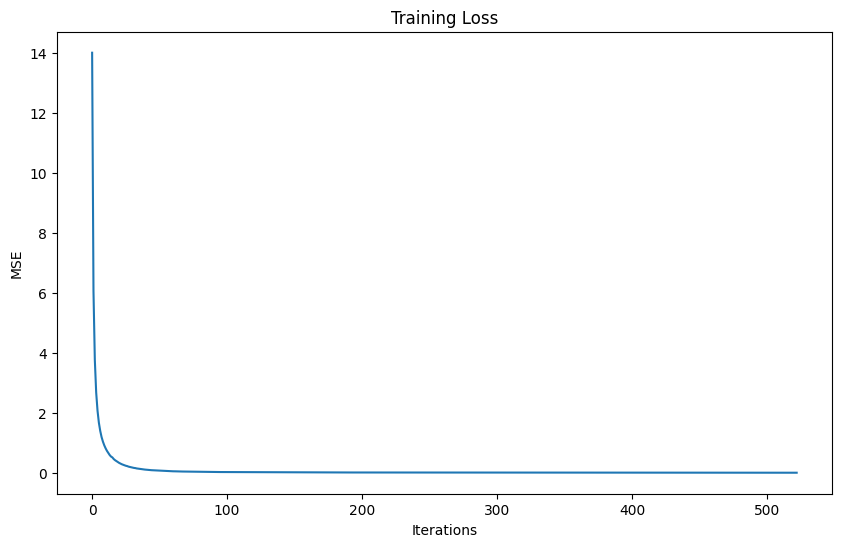

In [37]:
training_loss = spotify_model_pipelines.get('custom_gdReg_batch').steps[1][1].cost_history_
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label="Training Loss")
plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title("Training Loss")
plt.show()

In [ ]:
# model = CustomGradientDescentRegWithBatches(tol=tol, learning_rate=0.005, random_state=42)
# test_pipe = Pipeline(steps=[
#     ('preprocessor', spotify_preprocessor),
#     ('regressor', model)
# ])
# test_pipe.fit(X_train, y_train)
#
# y_pred = test_pipe.predict(X_test)
#
# # Sort the data (optional, for smoothness if X_test is not ordered)
# # sorted_idx = np.argsort(spotify_preprocessor.fit_transform(X_test).squeeze())  # Sort by feature, works for 1D or single feature problems
# # X_test_sorted = X_test.squeeze()[sorted_idx]
# # y_test_sorted = y_test[sorted_idx]
# # y_pred_sorted = y_pred[sorted_idx]
#
# # Plot True Values (Points)
# plt.figure(figsize=(10, 6))
# plt.plot(X_test, test_pipe.predict(X_test), color='red', label='Model Predictions', linewidth=2)
# plt.scatter(X_test, y_test, color='blue', label='True Values', alpha=0.8)
#
# # Plot Model Predictions (Line)
#
# # Add labels, title, and legend
# plt.xlabel("Feature (X_test)")
# plt.ylabel("Target / Predicted Value")
# plt.title("True Values (Points) vs Model Predictions (Line)")
# plt.legend()
# plt.grid()
# plt.show()
#


Test set results

In [38]:
for pipeline_name, pipeline in spotify_model_pipelines.items():
    print_results(pipeline_name, mean_squared_error(y_test, pipeline.predict(X_test)), pipeline.score(X_test, y_test))

Model: custom_linReg
MSE: 0.00172731
Score: 0.734714
------------------------------------------
Model: linReg
MSE: 0.00172731
Score: 0.734714
------------------------------------------
Model: custom_gdReg
MSE: 0.223685
Score: -33.3543
------------------------------------------
Model: custom_gdReg_batch
MSE: 0.00469972
Score: 0.2782
------------------------------------------
Model: sgdReg
MSE: 0.00178779
Score: 0.725425
------------------------------------------
Model: rfReg
MSE: 0.00160631
Score: 0.753297
------------------------------------------
Model: gbReg
MSE: 0.00170166
Score: 0.738654
------------------------------------------


#### With cross-validation (KFold with three splits)

In [39]:
@dataclass
class KFoldResult:
    train_mse_scores: list[float]
    train_r2_scores: list[float]
    test_mse_scores: list[float]
    test_r2_scores: list[float]

    def get_test_mse(self):
        return np.mean(self.test_mse_scores)

    def get_train_mse(self):
        return np.mean(self.train_mse_scores)

    def get_test_r2(self):
        return np.mean(self.test_r2_scores)

    def get_train_r2(self):
        return np.mean(self.train_r2_scores)


def train_with_k_fold(pipelines) -> dict[str, KFoldResult]:
    kf = KFold(n_splits=3, shuffle=True, random_state=1)
    train_mse_scores = {model_name: [] for model_name in pipelines.keys()}
    train_r2_scores = {model_name: [] for model_name in pipelines.keys()}
    test_mse_scores = {model_name: [] for model_name in pipelines.keys()}
    test_r2_scores = {model_name: [] for model_name in pipelines.keys()}

    for train_index, test_index in kf.split(X):
        X_cv_train, X_cv_val = X.iloc[train_index], X.iloc[test_index]
        y_cv_train, y_cv_val = y.iloc[train_index], y.iloc[test_index]
        y_cv_train = y_cv_train.fillna(df[target].median())
        y_cv_val = y_cv_val.fillna(df[target].median())
        for pipeline_name, pipeline in pipelines.items():
            pipeline.fit(X_cv_train, y_cv_train)
            y_cv_pred = pipeline.predict(X_cv_val)
            y_cv_train_pred = pipeline.predict(X_cv_train)

            train_mse_scores[pipeline_name].append(mean_squared_error(y_cv_train, y_cv_train_pred))
            train_r2_scores[pipeline_name].append(r2_score(y_cv_train, y_cv_train_pred))
            test_mse_scores[pipeline_name].append(mean_squared_error(y_cv_val, y_cv_pred))
            test_r2_scores[pipeline_name].append(r2_score(y_cv_val, y_cv_pred))

    return {pipeline_name : KFoldResult(train_mse_scores[pipeline_name], train_r2_scores[pipeline_name], test_mse_scores[pipeline_name], test_r2_scores[pipeline_name]) for pipeline_name in pipelines.keys()}

Train the models with k_fold

In [43]:
training_results = train_with_k_fold(spotify_model_pipelines)

def print_k_fold_results(pipelines, k_fold_results: dict[str, KFoldResult], print_test: bool):
    for pipeline_name in pipelines.keys():
        current_result = k_fold_results[pipeline_name]
        if print_test:
            print_results(pipeline_name, current_result.get_test_mse(), current_result.get_test_r2())
        else:
            print_results(pipeline_name, current_result.get_train_mse(), current_result.get_train_r2())

Training set results


In [46]:
print_k_fold_results(spotify_model_pipelines, training_results, print_test=False)

Model: custom_linReg
MSE: 0.00164632
Score: 0.75541
------------------------------------------
Model: linReg
MSE: 0.00164632
Score: 0.75541
------------------------------------------
Model: custom_gdReg
MSE: 0.161178
Score: -23.0424
------------------------------------------
Model: custom_gdReg_batch
MSE: 0.00579179
Score: 0.14243
------------------------------------------
Model: sgdReg
MSE: 0.00174677
Score: 0.740427
------------------------------------------
Model: rfReg
MSE: 0.00022543
Score: 0.966506
------------------------------------------
Model: gbReg
MSE: 0.00143883
Score: 0.786224
------------------------------------------


Test set results

In [47]:
print_k_fold_results(spotify_model_pipelines, training_results, print_test=True)

Model: custom_linReg
MSE: 0.00171507
Score: 0.745008
------------------------------------------
Model: linReg
MSE: 0.00171507
Score: 0.745008
------------------------------------------
Model: custom_gdReg
MSE: 0.1713
Score: -24.2703
------------------------------------------
Model: custom_gdReg_batch
MSE: 0.00705641
Score: -0.0587309
------------------------------------------
Model: sgdReg
MSE: 0.00179956
Score: 0.732581
------------------------------------------
Model: rfReg
MSE: 0.00158691
Score: 0.763981
------------------------------------------
Model: gbReg
MSE: 0.00165398
Score: 0.754034
------------------------------------------


#### Adding L1 and L2 regularization

Defining models with both L1 and L2 regularization

In [48]:
class CustomLinearRegressionWithL1(CustomModel):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = alpha

    def fit(self, X, y):
        X, y = self.prepare_data(X, y)
        X_design = np.c_[np.ones(X.shape[0]), X]
        I = np.eye(X_design.shape[1])
        I[0, 0] = 0

        regularized_matrix = X_design.T @ X_design + self.alpha * I
        pseudo_inverse = np.linalg.inv(regularized_matrix) @ X_design.T
        weights = pseudo_inverse @ y

        self.intercept_ = weights[0]
        self.coef_ = weights[1:]
        return self


spotify_model_pipelines_with_reg = {}

alpha = 1.0
add_spotify_model_pipeline(CustomLinearRegressionWithL1(alpha), 'custom_L1', spotify_model_pipelines_with_reg)
add_spotify_model_pipeline(Ridge(alpha=alpha, random_state=42), 'L1Reg', spotify_model_pipelines_with_reg)
add_spotify_model_pipeline(Lasso(alpha=alpha, random_state=42), 'L2Reg', spotify_model_pipelines_with_reg)
add_spotify_model_pipeline(SGDRegressor(tol=tol, learning_rate='invscaling', random_state=42, penalty='l1', alpha=alpha), 'sgdRegL1', spotify_model_pipelines_with_reg)
add_spotify_model_pipeline(SGDRegressor(tol=tol, learning_rate='invscaling', random_state=42, penalty='l2', alpha=alpha), 'sgdRegL2', spotify_model_pipelines_with_reg)

Train the models with K-fold

In [81]:
training_results_with_reg = train_with_k_fold(spotify_model_pipelines_with_reg)

Weights before and after L1 regularisation for linear regression

In [82]:
print("Before:")
weights_before = spotify_model_pipelines['custom_linReg'].steps[1][1].coef_
print(weights_before)
print("After:")
weights_after = spotify_model_pipelines_with_reg['custom_L1'].steps[1][1].coef_
print(weights_after)
print("Difference:")
print(weights_after - weights_before)

Before:
[ 3.49847342e-03  2.00483316e-02  9.44777690e-04 -1.52824511e-03
 -5.76636663e-04 -1.03571031e-03 -2.66891736e-03  2.79151510e-04
  5.07022363e-04  1.87957582e-03  4.20510068e-03 -5.20798223e-03
  1.00671162e-03  4.51916446e-02  4.06215955e-02  4.78976922e-02
  7.45034793e-02  5.92074530e-02  5.86328296e-02  7.50781027e-02
  7.18428988e-02  6.18680335e-02  5.81440991e-04 -3.65191261e-03
  5.03408395e-04  6.53338910e-04 -1.03728776e-03  8.17803006e-04
  1.28004634e-03  1.43933696e-05 -1.19722170e-03 -1.94395746e-03
 -4.82796287e-04 -1.13250059e-04  1.96333020e-03  5.67708160e-04
  2.62486088e-03  3.05904386e-04  1.11534949e-03  2.38312393e-03
  1.63364567e-03  1.86482775e-03 -2.02527246e-03  5.52374588e-03
 -1.48978342e-02  5.02124073e-04  9.96797115e-04 -5.76731223e-03
  1.24841144e-04  7.11073058e-03  3.69774652e-04  2.93036270e-03
 -3.80561410e-03 -1.78222194e-03  3.12547651e-03  3.07972113e-05
  5.29287309e-03  9.25036150e-03  5.50509698e-03  1.04815946e-02
  9.56673694e-03 

Training results

In [83]:
print_k_fold_results(spotify_model_pipelines_with_reg, training_results_with_reg, print_test=False)

Model: custom_L1
MSE: 0.00164633
Score: 0.755408
------------------------------------------
Model: L1Reg
MSE: 0.00164633
Score: 0.755408
------------------------------------------
Model: L2Reg
MSE: 0.00673185
Score: 0.0
------------------------------------------
Model: sgdRegL1
MSE: 0.00673279
Score: -0.000142045
------------------------------------------
Model: sgdRegL2
MSE: 0.0021217
Score: 0.684863
------------------------------------------


Test results

In [84]:
print_k_fold_results(spotify_model_pipelines_with_reg, training_results_with_reg, print_test=True)

Model: custom_L1
MSE: 0.00171481
Score: 0.745047
------------------------------------------
Model: L1Reg
MSE: 0.00171481
Score: 0.745047
------------------------------------------
Model: L2Reg
MSE: 0.00673588
Score: -0.000882451
------------------------------------------
Model: sgdRegL1
MSE: 0.00673351
Score: -0.000546611
------------------------------------------
Model: sgdRegL2
MSE: 0.00216187
Score: 0.678562
------------------------------------------


#### Hyperparameter tuning
Choosing the best performing models (Ridge regression, SGD) for parameter tuning. RF regressor and GradientBoost regressor skipped due to very high computional cost.

In [90]:
X_trans_train= spotify_preprocessor.fit_transform(X=X_train)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

def grid_search_cv(model_name, config, random_search):
    print(f"GridSearchCV for {model_name}")
    if random_search:
        grid_search = RandomizedSearchCV(
            estimator=config['model'],
            param_distributions=config['params'],
            n_iter=55,
            scoring=scorer,
            cv=5,
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
    else:
        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['params'],
            scoring=scorer,
            cv=5,
            n_jobs=-1,
            verbose=10,
        )
    grid_search.fit(X_trans_train, y_train)

    print(f"Best parameters for {model_name}:")
    param_list = []
    for param_name, param_value in grid_search.best_params_.items():
        param_list.append(f"{param_name}={param_value}")
    print(f"{model_name}(" + ", ".join(param_list) + ")")
    print(f"Best score for {model_name}: {grid_search.best_score_}")


GridSearchCV for Ridge regression

In [86]:
ridge_conf = {
    'model': Ridge(random_state=42, tol=tol),
    'params': {
        'alpha': loguniform(0.0001, 100)
    }
}
grid_search_cv('Ridge', ridge_conf, True)

GridSearchCV for Ridge
Fitting 5 folds for each of 55 candidates, totalling 275 fits
Best parameters for Ridge:
Ridge(alpha=15.741890047456648)
Best score for Ridge: -0.001706411672508681


GridSearchCV for SGD

In [88]:
sgd_conf = {
    'model': SGDRegressor(random_state=42, tol=tol, max_iter=5000),
    'params': {
        'alpha': loguniform(0.0001, 100),
        'penalty': ['l2', 'l1', 'elasticnet', None],
        'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
    }
}
grid_search_cv('SGDRegressor', sgd_conf, True)

GridSearchCV for SGDRegressor
Fitting 5 folds for each of 55 candidates, totalling 275 fits
Best parameters for SGDRegressor:
SGDRegressor(alpha=0.00010792764548678457, learning_rate=invscaling, penalty=elasticnet)
Best score for SGDRegressor: -0.0017687449450905983


### Ensemble methods

Chosen best performing models (Ridge regression, SGD, RF regressor, GB regressor) with optimal parameters deducted by the GridSearchCV or the default ones. Alpha parameters are rounded up to six decimal places.

In [97]:
best_ridge = Ridge(alpha=15.741890, random_state=42)
best_sgd = SGDRegressor(alpha=np.float64(0.000108), learning_rate='invscaling', penalty='elasticnet', max_iter=5000, random_state=42)
best_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
best_gb = GradientBoostingRegressor(random_state=42)

#### Stacking regressor

In [98]:
stacker = StackingRegressor(estimators=[
    ('ridge', best_ridge),
    ('sgd', best_sgd),
    ('rf', best_rf),
    ('gb', best_gb)
], n_jobs=-1)
stacking_pipeline = Pipeline(steps=[
    ('preprocessor', spotify_preprocessor),
    ('regressor', stacker)
])

Train the stacking regressor

In [99]:
stacking_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('column',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median')),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['Danceability',
                                                                    'Energy',
                                                                    'Key',
                                                                    'Speechiness',
                                                                    'Acousticness',
                                                                    'Liveness',
                                                                    'Valence',
                                                                    'Tempo',
                                                                    'Duration_ms',
                                                                    'Views',
                                                                    'Likes',
                                                                    'Comments',
                                                                    'Stream']),
                                                                  ('categorical',
                                                                   Pi...
                                  PolynomialFeatures(include_bias=False))])),
                ('regressor',
                 StackingRegressor(estimators=[('ridge',
                                                Ridge(alpha=15.74189,
                                                      random_state=42)),
                                               ('sgd',
                                                SGDRegressor(alpha=np.float64(0.000108),
                                                             max_iter=5000,
                                                             penalty='elasticnet',
                                                             random_state=42)),
                                               ('rf',
                                                RandomForestRegressor(n_jobs=-1,
                                                                      random_state=42)),
                                               ('gb',
                                                GradientBoostingRegressor(random_state=42))],
                                   n_jobs=-1))])

Training data results

In [100]:
print_results('Stacking regressor', mean_squared_error(y_train, stacking_pipeline.predict(X_train)), stacking_pipeline.score(X_train, y_train))

Model: Stacking regressor
MSE: 0.000552179
Score: 0.918652
------------------------------------------


Test data results

In [101]:
print_results('Stacking regressor', mean_squared_error(y_test, stacking_pipeline.predict(X_test)), stacking_pipeline.score(X_test, y_test))

Model: Stacking regressor
MSE: 0.00157462
Score: 0.758164
------------------------------------------


## Regression model in PyTorch

In [167]:
class TorchModelWrapper:
    def __init__(self, batch_size=64, num_epochs=300, patience=32):
        self.n_features = None
        self.model = None
        self.criterion = nn.MSELoss()
        self.optimizer = None
        self.scheduler = None
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.patience = patience
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.train_losses = []
        self.val_losses = []
        self.r2_scores = []
        torch.manual_seed(42)
        np.random.seed(42)

    def fit(self, X_train, y_train, verbose=False):
        X_train_transformed = tensor(spotify_preprocessor.fit_transform(X_train), dtype=float32)
        y_train_tensor = tensor(y_train.values, dtype=float32)
        train_dataset = TensorDataset(X_train_transformed, y_train_tensor)

        self.n_features = X_train_transformed.shape[1]
        self.model = nn.Linear(self.n_features, 1)
        self.optimizer = AdamW(self.model.parameters(), lr=0.01, weight_decay=1e-5)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', patience=5, factor=0.5)

        train_size = int(0.8 * len(train_dataset))
        val_size = len(train_dataset) - train_size
        train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
        train_loader = DataLoader(train_subset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=self.batch_size)
        counter = 0
        best_val_loss = float('inf')
        best_model_state = None

        for epoch in range(self.num_epochs):
            train_loss = self._train_epoch(train_loader)
            self.train_losses.append(train_loss)
            val_loss, r2 = self._validate(val_loader)
            self.val_losses.append(val_loss)
            self.r2_scores.append(r2)
            self.scheduler.step(val_loss)

            if verbose and (epoch + 1) % 5 == 0:
                print(f"Epoch {epoch + 1}/{self.num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, R^2: {r2:.6f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
                best_model_state = copy.deepcopy(self.model.state_dict())
            else:
                counter += 1
                if counter >= self.patience:
                    if verbose:
                        print(f"Early stopping at epoch {epoch + 1}")
                    break

        self.model.load_state_dict(best_model_state)
        self.model.eval()
        return self

    def _train_epoch(self, data_loader) -> float:
        self.model.train()
        running_loss = 0.0
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
            self.optimizer.zero_grad()
            y_pred = self.model(X_batch).squeeze()
            loss = self.criterion(y_pred, y_batch)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item() * X_batch.size(0)
        return running_loss / len(data_loader.dataset)

    def _validate(self, data_loader) -> tuple[float, float]:
        self.model.eval()
        running_loss = 0.0
        all_predictions = []
        all_targets = []
        with no_grad():
            for X_batch, y_batch in data_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                y_pred = self.model(X_batch).squeeze()
                loss = self.criterion(y_pred, y_batch)
                running_loss += loss.item() * X_batch.size(0)
                all_predictions.extend(y_pred.cpu().numpy().flatten())
                all_targets.extend(y_batch.cpu().numpy().flatten())
        y_true = np.array(all_targets)
        y_pred = np.array(all_predictions)
        r2 = 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)
        return running_loss / len(data_loader.dataset), r2

    def predict(self, X, is_transformed=True):
        X_test_tensor = tensor(spotify_preprocessor.fit_transform(X) if not is_transformed else X, dtype=float32)
        self.model.eval()
        X_test_tensor = X_test_tensor.to(self.device)
        with torch.no_grad():
            predictions = self.model(X_test_tensor).squeeze()
        return predictions.cpu().numpy()

Train the model

In [168]:
torch_model = TorchModelWrapper()
torch_model.fit(X_train, y_train, verbose=True)

Epoch 5/300, Train Loss: 0.0084, Val Loss: 0.0071, R^2: -0.110512
Epoch 10/300, Train Loss: 0.0052, Val Loss: 0.0032, R^2: 0.501074
Epoch 15/300, Train Loss: 0.0028, Val Loss: 0.0023, R^2: 0.636982
Epoch 20/300, Train Loss: 0.0032, Val Loss: 0.0025, R^2: 0.602386
Epoch 25/300, Train Loss: 0.0023, Val Loss: 0.0026, R^2: 0.598009
Epoch 30/300, Train Loss: 0.0019, Val Loss: 0.0019, R^2: 0.698482
Epoch 35/300, Train Loss: 0.0020, Val Loss: 0.0020, R^2: 0.688561
Epoch 40/300, Train Loss: 0.0019, Val Loss: 0.0018, R^2: 0.712048
Epoch 45/300, Train Loss: 0.0018, Val Loss: 0.0018, R^2: 0.724937
Epoch 50/300, Train Loss: 0.0019, Val Loss: 0.0018, R^2: 0.721627
Epoch 55/300, Train Loss: 0.0018, Val Loss: 0.0018, R^2: 0.725114
Epoch 60/300, Train Loss: 0.0017, Val Loss: 0.0017, R^2: 0.727963
Epoch 65/300, Train Loss: 0.0017, Val Loss: 0.0017, R^2: 0.735331
Epoch 70/300, Train Loss: 0.0017, Val Loss: 0.0017, R^2: 0.732359
Epoch 75/300, Train Loss: 0.0017, Val Loss: 0.0017, R^2: 0.731507
Epoch 80/3

#

#### Training set results

In [169]:
y_pred_train = torch_model.predict(X_train, is_transformed=False)
print_results('Torch model', mean_squared_error(y_train, y_pred_train), r2_score(y_train, y_pred_train))

Model: Torch model
MSE: 0.00167057
Score: 0.753889
------------------------------------------


#### Test set results

In [171]:
y_pred_test = torch_model.predict(X_test, is_transformed=False)
print_results('Torch model', mean_squared_error(y_test, y_pred_test), r2_score(y_test, y_pred_test))

Model: Torch model
MSE: 0.00173478
Score: 0.733566
------------------------------------------


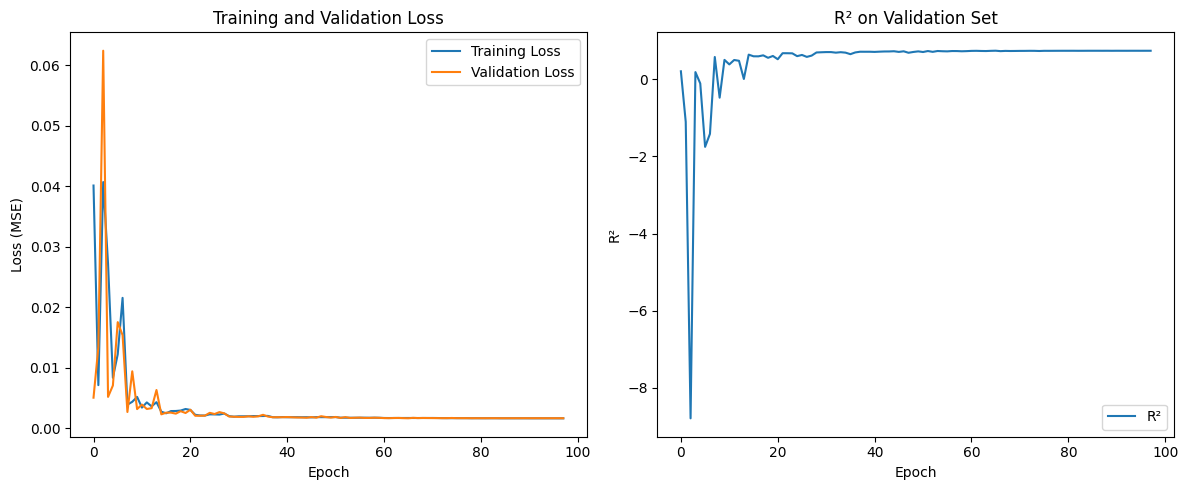

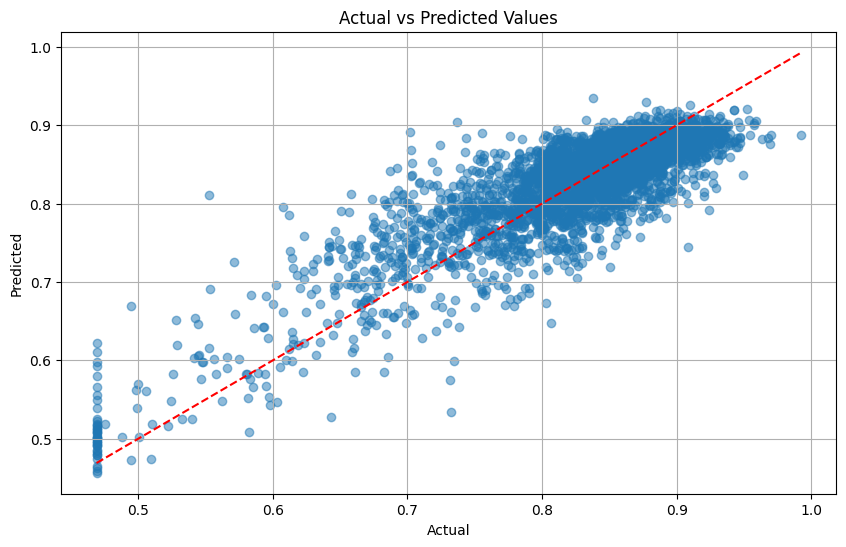

In [172]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(torch_model.train_losses, label='Training Loss')
plt.plot(torch_model.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(torch_model.r2_scores, label='R²')
plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('R² on Validation Set')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values')
plt.grid(True)
plt.show()


### Mixture of experts model

Choosing the best models as experts and splitting the data into 65% for training models, 20% for training the gating model and 15% for testing the MoE model

In [173]:
X_train_set, X_test_moe, y_train_set, y_test_moe = train_test_split(X, y, test_size=0.15, random_state=42)
y_train_set = y_train_set.fillna(df[target].median())
y_test_moe = y_test_moe.fillna(df[target].median())
X_train_experts, X_train_gating, y_train_experts, y_train_gating = train_test_split(X_train_set, y_train_set, test_size=0.17, random_state=42)
X_train_gating = spotify_preprocessor.fit_transform(X_train_gating)
X_test_moe = spotify_preprocessor.fit_transform(X_test_moe)

experts = {
    ('ridge', best_ridge),
    ('sgd', best_sgd),
    ('rf', best_rf),
    ('gb', best_gb),
    ('torch', TorchModelWrapper())
}
expert_pipelines = {}

for expert_name, expert_model in experts:
    if expert_name == 'torch':
        expert_pipelines['torch'] = expert_model
    else:
        add_spotify_model_pipeline(expert_model, expert_name, expert_pipelines)

Pretraining the models:

In [174]:
for pipeline_name, pipeline in expert_pipelines.items():
    print(f'Training pipeline: {pipeline_name}')
    pipeline.fit(X_train_experts, y_train_experts)

Training pipeline: sgd
Training pipeline: gb
Training pipeline: ridge
Training pipeline: rf
Training pipeline: torch


Defining a Top-K gating model that uses pretrained expert models

In [181]:
class TopKGatingModel:
    def __init__(self, expert_models, k):
        self.expert_models = expert_models
        self.n_experts = len(expert_models)
        self.k = min(k, max(self.n_experts-1, 1))
        self.gater = LogisticRegression(
            solver='lbfgs',
            max_iter=1000,
        )

    def fit(self, X, y):
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        best_expert_indices = np.zeros(len(X), dtype=int)
        for train_idx, val_idx in kf.split(X):
            X_val, y_val = X[val_idx], y.iloc[val_idx]
            expert_errors = []
            for expert in self.expert_models:
                y_pred = expert.predict(X_val)
                errors = np.abs(y_pred - y_val)
                expert_errors.append(errors)
            expert_errors = np.column_stack(expert_errors)
            best_expert_indices[val_idx] = np.argmin(expert_errors, axis=1)
        self.gater.fit(X, best_expert_indices)
        return self

    def predict_top_k_weights(self, X):
        all_weights = self.gater.predict_proba(X)
        top_k_indices = np.argsort(-all_weights, axis=1)[:, :self.k]
        top_k_weights = np.array([
            all_weights[i, top_k_indices[i]] for i in range(len(X))
        ])
        top_k_weights = top_k_weights / top_k_weights.sum(axis=1, keepdims=True)
        return top_k_indices, top_k_weights


Define the Mixture of Experts model

In [202]:
class TopKMixtureOfExperts:
    def __init__(self, k=2):
        self.k = k
        self.expert_models = None
        self.expert_names = None
        self.gating_model = None

    def fit(self, experts, X_train_gate, y_train_gate):
        expert_names, expert_models = zip(*experts)
        self.expert_models = list(expert_models)
        self.expert_names = list(expert_names)
        self.gating_model = TopKGatingModel(self.expert_models, k=self.k)
        self.gating_model.fit(X_train_gate, y_train_gate)
        return self

    def predict(self, X, verbose=False):
        num_samples = len(X)
        top_k_indices, top_k_weights = self.gating_model.predict_top_k_weights(X)
    
        expert_preds = {}
        for expert_idx in np.unique(top_k_indices):
            expert_preds[expert_idx] = self.expert_models[expert_idx].predict(X)
    
        final_predictions = np.zeros(num_samples)
        
        for i in range(num_samples):
            preds = np.array([expert_preds[expert_idx][i] for expert_idx in top_k_indices[i]])
            final_predictions[i] = np.sum(preds * top_k_weights[i])
            if verbose:
                print(f"[Sample {i}] Experts: {top_k_indices[i]}, Weights: {top_k_weights[i]}. Used {", ".join(self.expert_names[j] for j in top_k_indices[i])}")
        return final_predictions


Train the gating model in MoE

In [209]:
moe_model = TopKMixtureOfExperts(k=2)
moe_model.fit(experts, X_train_gating, y_train_gating)

Test data results

In [210]:
y_pred_test = moe_model.predict(X_test_moe, verbose=True)
print_results('MoE model', mean_squared_error(y_test_moe, y_pred_test), r2_score(y_test_moe, y_pred_test))

[Sample 0] Experts: [1 3], Weights: [0.68607388 0.31392612]. Used gb, rf
[Sample 1] Experts: [3 1], Weights: [0.65088235 0.34911765]. Used rf, gb
[Sample 2] Experts: [3 4], Weights: [0.50990481 0.49009519]. Used rf, torch
[Sample 3] Experts: [1 4], Weights: [0.58962038 0.41037962]. Used gb, torch
[Sample 4] Experts: [0 3], Weights: [0.75113156 0.24886844]. Used sgd, rf
[Sample 5] Experts: [1 3], Weights: [0.68781644 0.31218356]. Used gb, rf
[Sample 6] Experts: [0 3], Weights: [0.59111019 0.40888981]. Used sgd, rf
[Sample 7] Experts: [3 1], Weights: [0.91369095 0.08630905]. Used rf, gb
[Sample 8] Experts: [3 1], Weights: [0.6117226 0.3882774]. Used rf, gb
[Sample 9] Experts: [1 3], Weights: [0.58573593 0.41426407]. Used gb, rf
[Sample 10] Experts: [2 3], Weights: [0.56776715 0.43223285]. Used ridge, rf
[Sample 11] Experts: [3 4], Weights: [0.66687329 0.33312671]. Used rf, torch
[Sample 12] Experts: [3 1], Weights: [0.61840005 0.38159995]. Used rf, gb
[Sample 13] Experts: [2 3], Weights: